<center><h2>Snake Arcade Game - A2C Algorithm</h2></center>

### Importing the required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


import gym
from gym import spaces


# Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

# import cv2
import random
import time
from collections import deque

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Defining functions for visualizations

In [4]:
class Snake(gym.Env):

    def __init__(self, visuals=False):
        super(Snake, self).__init__()
        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=-500, high=500, shape=(5+20,), dtype=np.float32)
        self.show_env = visuals
        self.timestep = 0
        self.timestep_max = 2000

    def step(self, action):
        self.prev_actions.append(action)
        self.timestep += 1

        
        if action == 0:
            self.head_direction = (self.head_direction + 1) % 4
        elif action == 1:
            self.head_direction = (self.head_direction - 1) % 4
        elif action == 2:
            pass
        
        if self.head_direction == 0:
            self.snake_head[0] += 10
        elif self.head_direction == 1:
            self.snake_head[1] += 10
        elif self.head_direction == 2:
            self.snake_head[0] -= 10
        elif self.head_direction == 3:
            self.snake_head[1] -= 10
            

        # Increase Snake length on eating apple
        apple_reward = 0
        if self.snake_head == self.apple_position:
            self.apple_count += 1
            self.apple_position = self.apple_position_list[self.apple_count]
            self.snake_position.insert(0,list(self.snake_head))
            apple_reward = 1000
            if len(self.snake_position) == MAX_SNAKE_LEN:
                self.reward += 500
                if self.show_env:
                    viz_game_win(self.apple_count)
            
        else:
            self.snake_position.insert(0,list(self.snake_head))
            self.snake_position.pop()
            
        
        if self.show_env:
            viz_game(self.snake_position, self.apple_position, self.snake_head, self.head_direction)
        
        
        # On collision end episode and print the score
        if boundary_collision(self.snake_head) == 1 or self_collision(self.snake_position) == 1:
            if self.show_env:
                viz_game_over(self.apple_count)
            self.done = True
            self.reward = -100


        # REWARD DYNAMICS
        euclidean_dist_to_apple = np.linalg.norm(np.array(self.snake_head) - np.array(self.apple_position))
        self.reward =  (150 - euclidean_dist_to_apple)/10 + apple_reward

        ## if snake dies
#         if self.done:
#             self.reward = -100                                     
        info = {}
    
        if self.timestep == self.timestep_max:
            self.done = True

        head_x = self.snake_head[0]
        head_y = self.snake_head[1]

        snake_length = len(self.snake_position)
        apple_delta_x = self.apple_position[0] - head_x
        apple_delta_y = self.apple_position[1] - head_y

        # create observation:
        observation = [head_x, head_y, apple_delta_x, apple_delta_y, snake_length] + list(self.prev_actions)
        observation = np.array(observation)

        return observation, self.reward, self.done, info

    def reset(self):
        
        # Initial Snake and Apple position
        self.snake_position = [[70,80],[60,80],[50,80]]
        self.apple_count = 0
        self.apple_position_list = [[110,60],[50,40],[50,80],[60,110],[70,110],[80,90],[110,60],\
                                    [40,50],[40,80],[40,110],[120,20],[120, 120],[30,120],[90,40],[30,20]]
        self.apple_position = self.apple_position_list[self.apple_count]
        
        self.prev_head_direction = 1
        self.head_direction = 0
        self.snake_head = [70,80]                                                           # head_x and head_y

        self.prev_reward = 0
        self.timestep = 0

        self.done = False                                                                     # Reset the environment after every episode and set done as False

        head_x = self.snake_head[0]
        head_y = self.snake_head[1]

        snake_length = len(self.snake_position)
        apple_delta_x = self.apple_position[0] - head_x
        apple_delta_y = self.apple_position[1] - head_y

        self.prev_actions = deque(maxlen = 20)
        for i in range(20):
            self.prev_actions.append(-1) 

        # create observation:
        observation = [head_x, head_y, apple_delta_x, apple_delta_y, snake_length] + list(self.prev_actions)
        observation = np.array(observation)

        return observation


### Defining helper functions to check if snake is terminated

In [5]:
## Checks if snake has collided with the boundary of the grid
def boundary_collision(snake_head):
     # When snake dimensions go beyond the grid dimensions
    if snake_head[0]>=150 or snake_head[0]<0 or snake_head[1]>=150 or snake_head[1]<0 :
        return 1 # True
    else:
        return 0 # False

    
## Checks if snake has collided with it's own body
def self_collision(snake_position):
    snake_head = snake_position[0]
    if snake_head in snake_position[1:]:
        return 1
    else:
        return 0

In [6]:
## Maximum length of snake before the episode terminates
MAX_SNAKE_LEN = 15

### Training the environment using A2C algorithm

#### Defining the neural networks and training loop for the agent

## A2C GPU

In [30]:
# Hyperparameters
learning_rate = 0.0001
gamma = 1.0
lmbda = 0.95
eps_clip = 0.1
K_epoch= 3
T_horizon = 5000


# torch.manual_seed(seed)
writer = SummaryWriter()

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
device

device(type='cuda')

In [22]:
class ActorCritic(nn.Module):
    def __init__(self, action_size=2, state_size=4):
        super(ActorCritic, self).__init__()
        self.data = []
        self.fc1 = nn.Linear(state_size, 128)
        self.fc_pi = nn.Linear(128, action_size)
        self.fc_v = nn.Linear(128, 1)
        self.to(device)  # Move the model to GPU device
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def actor(self, x, softmax_dim=0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def critic(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        states, actions, rewards, next_states, action_probs, dones = [], [], [], [], [], []
        for transition in self.data:
            state, action, reward, next_state, action_prob, done = transition
            states.append(state)
            actions.append([action])
            rewards.append([reward / 100.0])
            next_states.append(next_state)
            action_probs.append([action_prob])
            done_mask = 0.0 if done else 1.0
            dones.append([done_mask])

        states_batch = torch.tensor(np.array(states), dtype=torch.float, device=device)  # Move tensor to GPU device
        actions_batch = torch.tensor(actions, device=device)  # Move tensor to GPU device
        rewards_batch = torch.tensor(rewards, dtype=torch.float, device=device)  # Move tensor to GPU device
        next_states_batch = torch.tensor(np.array(next_states), dtype=torch.float, device=device)  # Move tensor to GPU device
        dones_batch = torch.tensor(dones, dtype=torch.float, device=device)  # Move tensor to GPU device
        action_probs_batch = torch.tensor(action_probs, device=device)  # Move tensor to GPU device
        self.data = []
        return states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch, action_probs_batch

    def train_net(self):
        states, actions, rewards, next_states, dones, action_probs = self.make_batch()
        first = True
        for i in range(K_epoch):
            td_target = rewards + gamma * self.critic(next_states) * dones
            delta = td_target - self.critic(states)
            delta = delta.detach().cpu().numpy()  # Move tensor to CPU

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]  # 0 is used because delta is a 2d array with only one element in it
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float, device=device)  # Move tensor to GPU device

            pi = self.actor(states, softmax_dim=1)
            pi_a = pi.gather(1, actions)
            ratio = torch.exp(torch.log(pi_a) - torch.log(action_probs))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.critic(states), td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            if first:
                writer.add_scalar("Loss", loss.mean().item(), 0)
                first = False
            else:
                writer.add_scalar("Loss", loss.mean().item(), i)
           
    # Save model parameters
    def save(self, path):
        torch.save(self.state_dict(), path)

    # Load model parameters
    def load(self, path):
        self.load_state_dict(torch.load(path))

#### Specifying the environment and defining the hyperparameters

In [23]:

EPISODES = 20000
reward_list_training = []
apple_list_training = []
timestep_list_training = []
max_apple_count = 1
reached = False

#### Training the agent for defined episodes

In [ ]:
# Initialize the Actor-Critic model and Env
env = Snake()
actor_critic = ActorCritic(action_size = env.action_space.n, state_size = env.observation_space.shape[0])


# Initialize variables for tracking scores and printing updates
# total_score = 0.0
print_interval = 100

# Begin training loop
# print("Start Training")
for e in range(EPISODES):
    state = env.reset()
    done = False
    episode_reward = 0.0
    timestep = 0
    while not done:
        for step in range(T_horizon):
            timestep += 1
            # Sample action from the policy
            action_probs = actor_critic.actor(torch.tensor(np.array(state), device = device).float()) ## From Numpy
            action_dist = Categorical(action_probs)
            action = action_dist.sample().item()

            # Take a step in the environment with the selected action
            next_state, reward, done, info = env.step(action)

            # Record transition and update variables
            actor_critic.put_data((state, action, reward, next_state, action_probs[action].item(), done))
            state = next_state
#             total_score += reward
            episode_reward += reward
            # Break if episode is done
            if done:
                if e % print_interval == 0:
                    print("Episode: {}/{}, Episode Reward: {}, Episode Apple Count: {}, Timestep: {}"
                          .format(e, EPISODES, episode_reward, env.apple_count, timestep))
                reward_list_training.append(episode_reward)
                apple_list_training.append(env.apple_count)
                timestep_list_training.append(timestep)
                
                actor_critic.save("a2c_weights.h5")
                break

        # Update the actor-critic model
        actor_critic.train_net()

env.close()
writer.close()

Episode: 0/20000, Episode Reward: 96.1877712895805, Episode Apple Count: 0, Timestep: 8
Episode: 100/20000, Episode Reward: 112.32995362229003, Episode Apple Count: 0, Timestep: 11
Episode: 200/20000, Episode Reward: 96.1877712895805, Episode Apple Count: 0, Timestep: 8
Episode: 300/20000, Episode Reward: 96.1877712895805, Episode Apple Count: 0, Timestep: 8
Episode: 400/20000, Episode Reward: 96.1877712895805, Episode Apple Count: 0, Timestep: 8
Episode: 500/20000, Episode Reward: 96.1877712895805, Episode Apple Count: 0, Timestep: 8
Episode: 600/20000, Episode Reward: 96.1877712895805, Episode Apple Count: 0, Timestep: 8
Episode: 700/20000, Episode Reward: 96.1877712895805, Episode Apple Count: 0, Timestep: 8
Episode: 800/20000, Episode Reward: 96.1877712895805, Episode Apple Count: 0, Timestep: 8
Episode: 900/20000, Episode Reward: 243.53329319707197, Episode Apple Count: 0, Timestep: 21
Episode: 1000/20000, Episode Reward: 213.6588333631234, Episode Apple Count: 0, Timestep: 18
Epi

#### Reward per episode during training

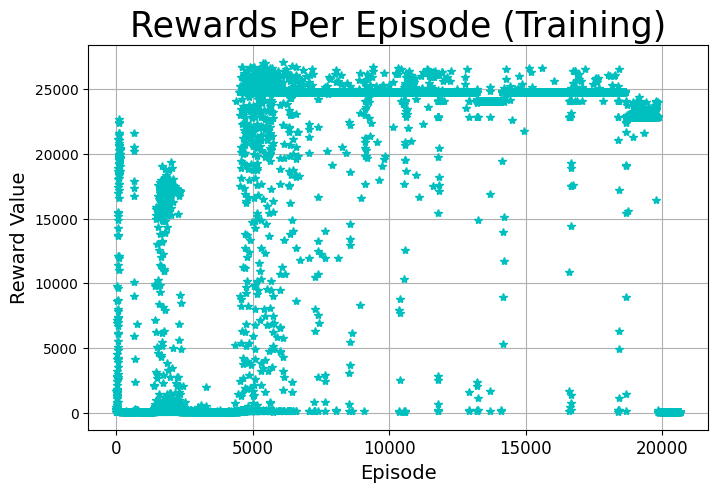

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(reward_list_training, 'c*')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Reward Value', fontsize=14)
plt.title('Rewards Per Episode (Training)', fontsize=25)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

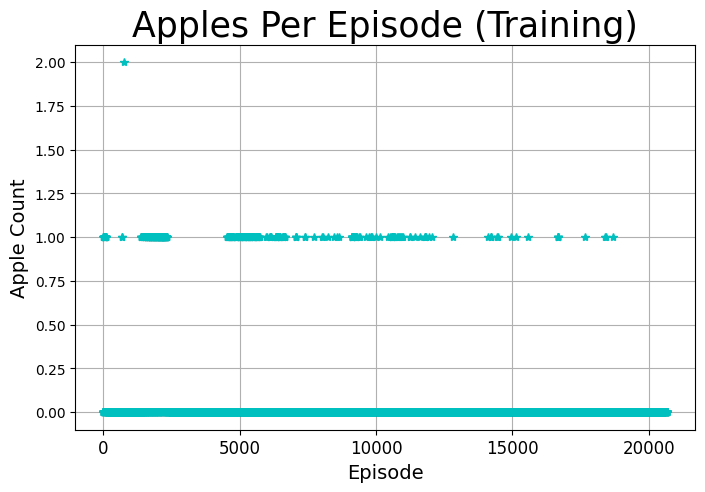

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(apple_list_training, 'c*')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Apple Count', fontsize=14)
plt.title('Apples Per Episode (Training)', fontsize=25)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

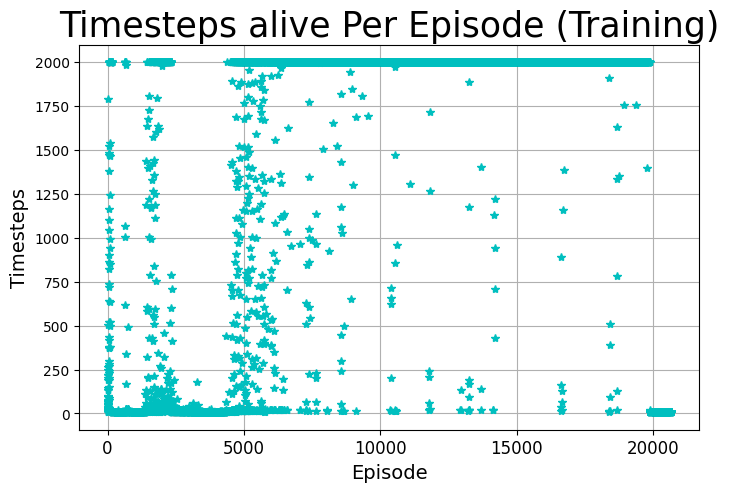

In [34]:
import matplotlib.pyplot as plt
# Plotting the Rewards
plt.figure(figsize=(8, 5))
plt.plot(timestep_list_training, 'c*')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Timesteps', fontsize=14)
plt.title('Timesteps alive Per Episode (Training)', fontsize=25)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

### Playing the snake environment using greedy policy

In [34]:

env = Snake()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = ActorCritic(action_size = env.action_space.n, state_size = env.observation_space.shape[0])
agent.load("/kaggle/input/data123456/billodal_syadavil_akhilshr_project_a2c_2.h5")
done = False
batch_size = 64
EPISODES = 100
scores_list = []
eps_list = []

In [35]:
apple_list_testing = []

In [36]:
for e in range(10):
    state = env.reset()
#     state = np.reshape(state, [1, state_size])
    done = False
    episode_reward = 0.0
    timestep = 0
    episode_action_list = []
    
    while(not done):
        action_probs = agent.actor(torch.tensor(np.array(state), device = device).float())
#         episode_action_list.append(action)
        action_dist = Categorical(action_probs)
        action = action_dist.sample().item()
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state
        episode_reward += reward
        timestep+=1
        if done:
            if e % 1 == 0:
                print("Episode: {}/{}, Episode Reward: {}, Episode Apple Count: {}, Timestep: {}"
                      .format(e, 10, episode_reward,  env.apple_count, timestep))
#             reward_list_testing.append(episode_reward)
            apple_list_testing.append(env.apple_count)
#             timestep_list_testing.append(timestep)
#     action_list.append(episode_action_list)

env.close()

Episode: 0/10, Episode Reward: 112.28588959559355, Episode Apple Count: 0, Timestep: 11
Episode: 1/10, Episode Reward: 555.7200695318477, Episode Apple Count: 0, Timestep: 65
Episode: 2/10, Episode Reward: 412.1944764831537, Episode Apple Count: 0, Timestep: 46
Episode: 3/10, Episode Reward: 1405.7172722110927, Episode Apple Count: 1, Timestep: 44
Episode: 4/10, Episode Reward: 231.1606876773161, Episode Apple Count: 0, Timestep: 29
Episode: 5/10, Episode Reward: 162.9037584395543, Episode Apple Count: 0, Timestep: 15
Episode: 6/10, Episode Reward: 521.4066007663282, Episode Apple Count: 0, Timestep: 55
Episode: 7/10, Episode Reward: 373.41300264970533, Episode Apple Count: 0, Timestep: 45
Episode: 8/10, Episode Reward: 242.76308810445573, Episode Apple Count: 0, Timestep: 20
Episode: 9/10, Episode Reward: 292.8707981085717, Episode Apple Count: 0, Timestep: 30


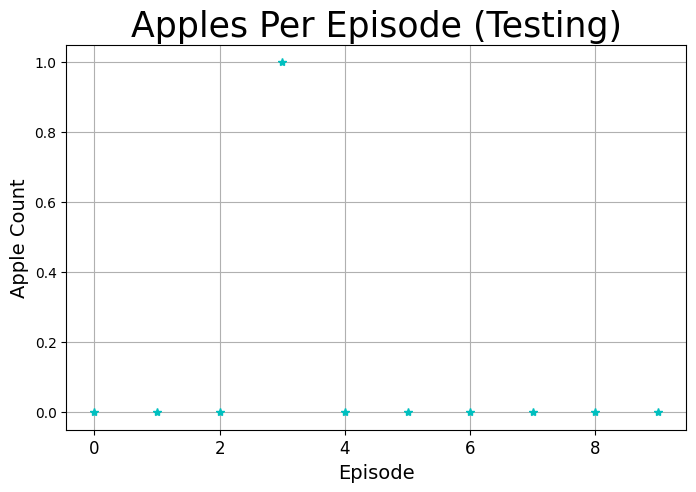

In [37]:
plt.figure(figsize=(8, 5))
plt.plot(apple_list_testing, 'c*')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Apple Count', fontsize=14)
plt.title('Apples Per Episode (Testing)', fontsize=25)
plt.xticks(fontsize=12)
plt.grid()
plt.show()